# Class 14: Introduction to Machine Learning 1 — General

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main

## Goals of today's class:
1. Take a whirlwind tour of the early(ish) history of unsupervised machine learning at a high level.
2. Learn what embeddings are and why they're useful
3. Discuss the Node2Vec paper and try out Node2Vec on a medium-sized dataset.

## What is Unsupervised Machine Learning?
Supervised machine learning is the practice of building a model when we have training data -- the information that we use to inform our model how the world works -- that has correct ground truth answers. When you're building a linear regression or a Naive Bayes classifier (for example), you're doing supervised machine learning. 

However, there are some times when we don't have access to exact ground truths about desired outcomes, and we have to build insights with our dataset anyway. That's where unsupervised machine learning comes in. When we do unsupervised ML, we figure out what patterns are present in unlabeled data. Clustering is one type of unsupervised machine learning technique; when we cluster a dataset, we're learning to recognize similar kinds of data points. Generating new examples is also an unsupervised ML task. Training ChatGPT and its ilk requires massive amounts of scraped text that doesn't have "answers" attached to it. At a high level, ChatGPT and friends are trained to produce text that we can't tell comes from a computer. 


## "Old" Unsupervised ML
Today we're going to start by going through some of the early ways people thought about unsupervised machine learning.

### Clustering
As mentioned above, one thing we do a lot in unsupervised settings is finding examples that are similar to each other. This can be useful for recommendation algorithms, pattern recognition, and more. K-means is a popular clustering algorithm that we'll try out today; it partitions the dataset into $k$ clusters, and each point is assigned to the cluster whose cetroid (its mean) is closest to that point. We're going to try out k-means clustering on a dataset of places and roads in North Jutland, Denmark.

First, let's visualize the dataset. What are we dealing with here?

<Axes: >

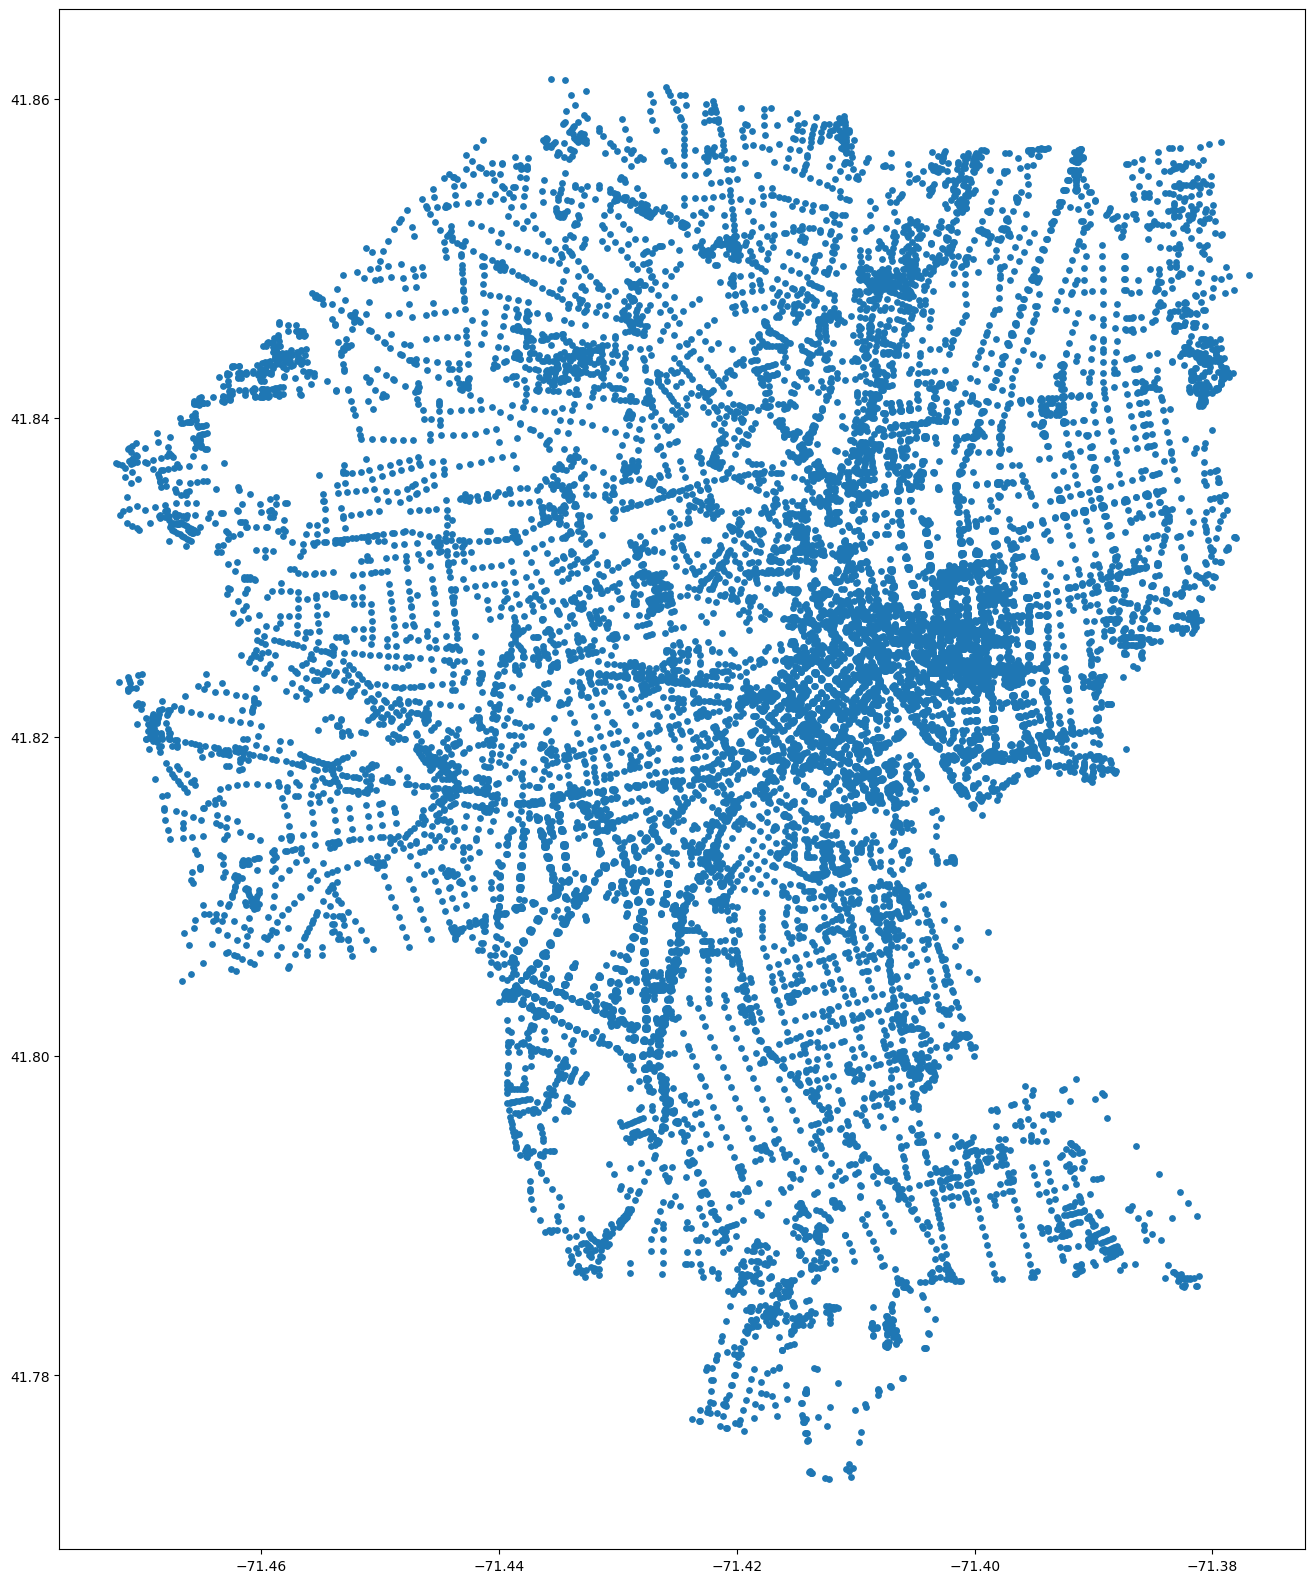

In [48]:
import osmnx as ox
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
S = 15

G = ox.graph_from_place('Providence, Rhode Island, United States')

points = [Point((G.nodes[i]['x'], G.nodes[i]['y'])) for i in G.nodes]
geo_df = gpd.GeoDataFrame(geometry = points, crs='EPSG:4326')

geo_df.plot(markersize=S)

### K-Means Clustering

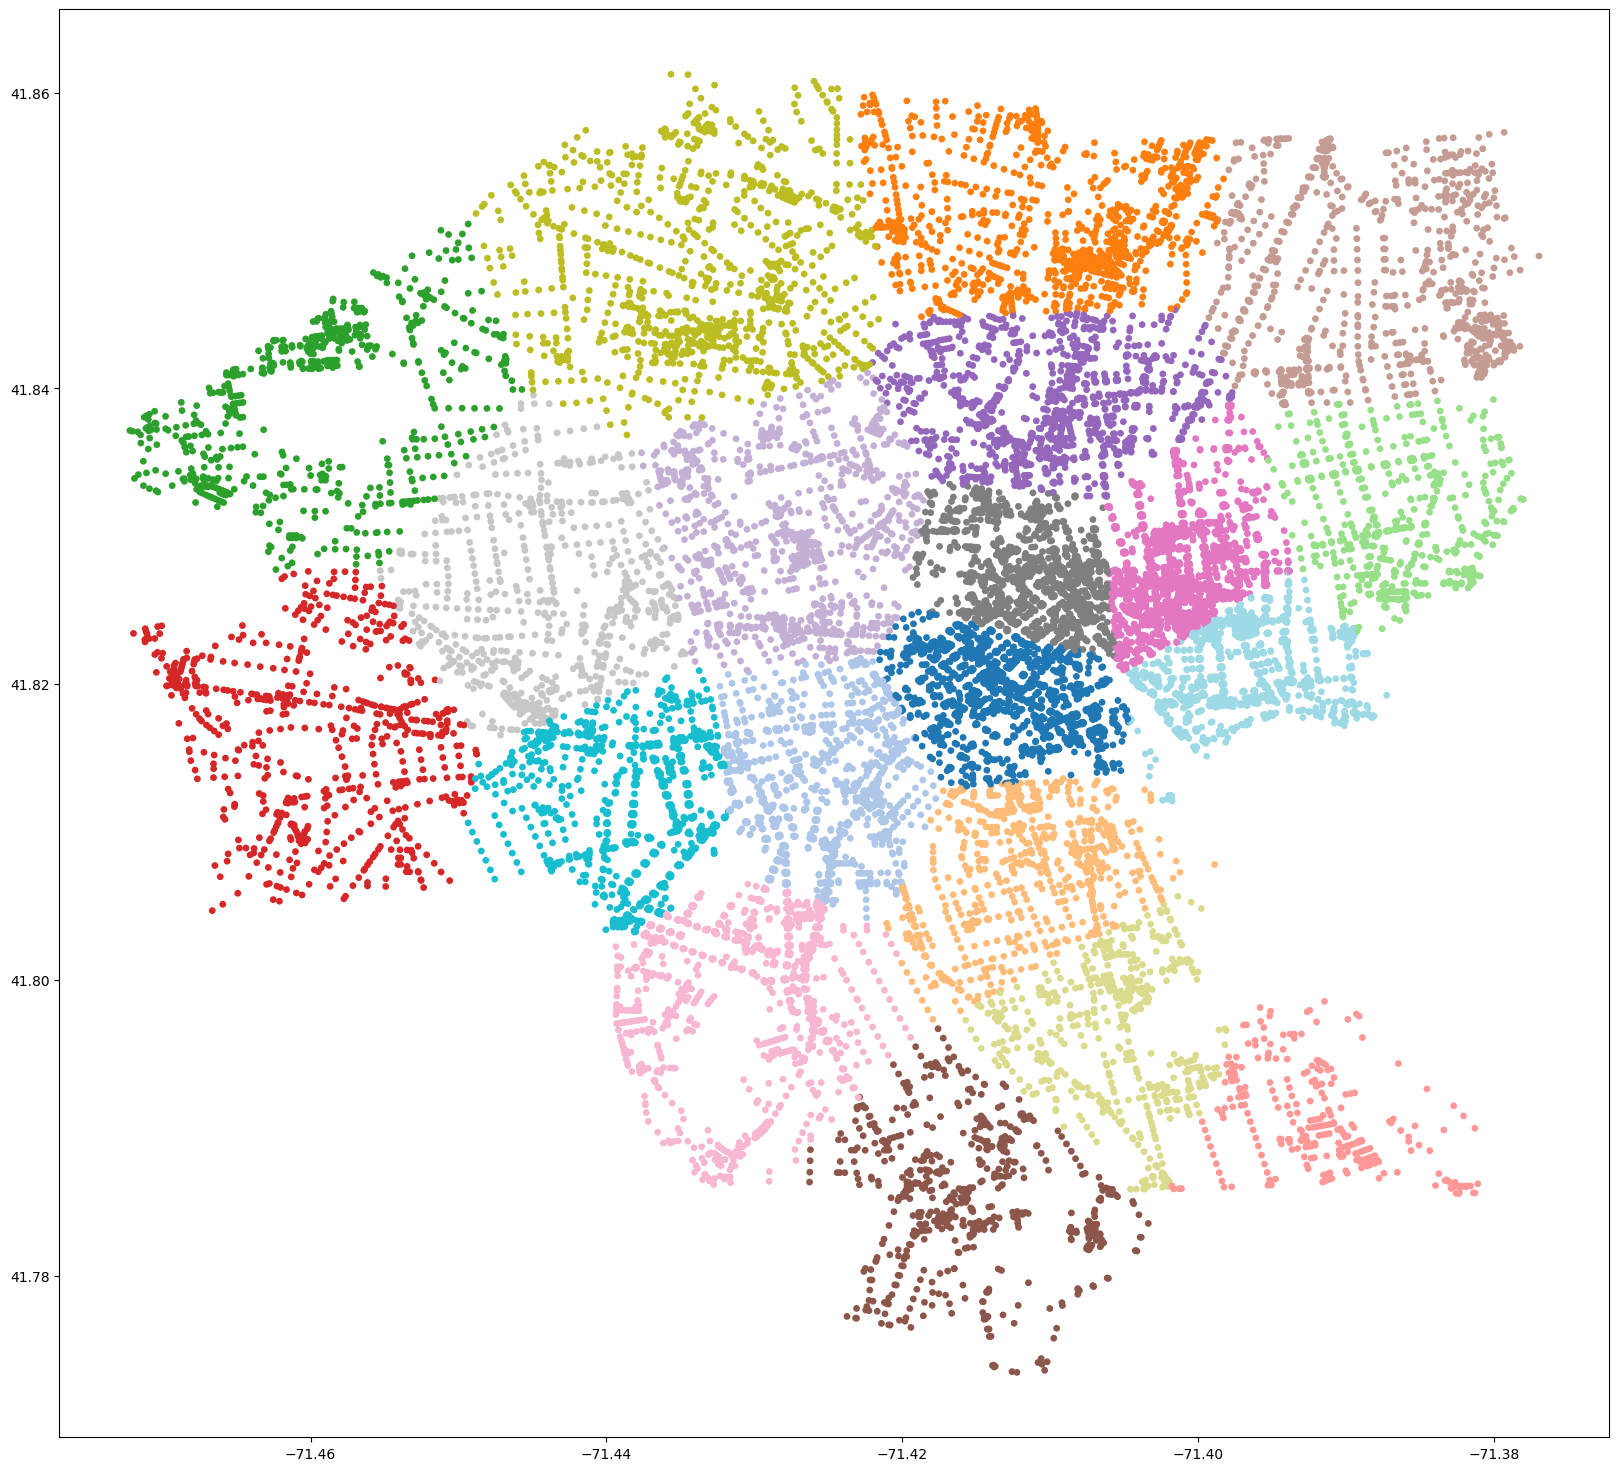

In [2]:
import matplotlib
import numpy as np
from sklearn.cluster import KMeans

K = 20

mtx = np.array([[G.nodes[i]['x'], G.nodes[i]['y']] for i in G.nodes])
kmeans = KMeans(n_clusters=K).fit(mtx)

cmap = plt.get_cmap('tab20')
geo_df["label"] = [matplotlib.colors.rgb2hex(cmap(i)) for i in kmeans.labels_]
plot = geo_df.plot(
    markersize=S,
    c=geo_df["label"], 
)


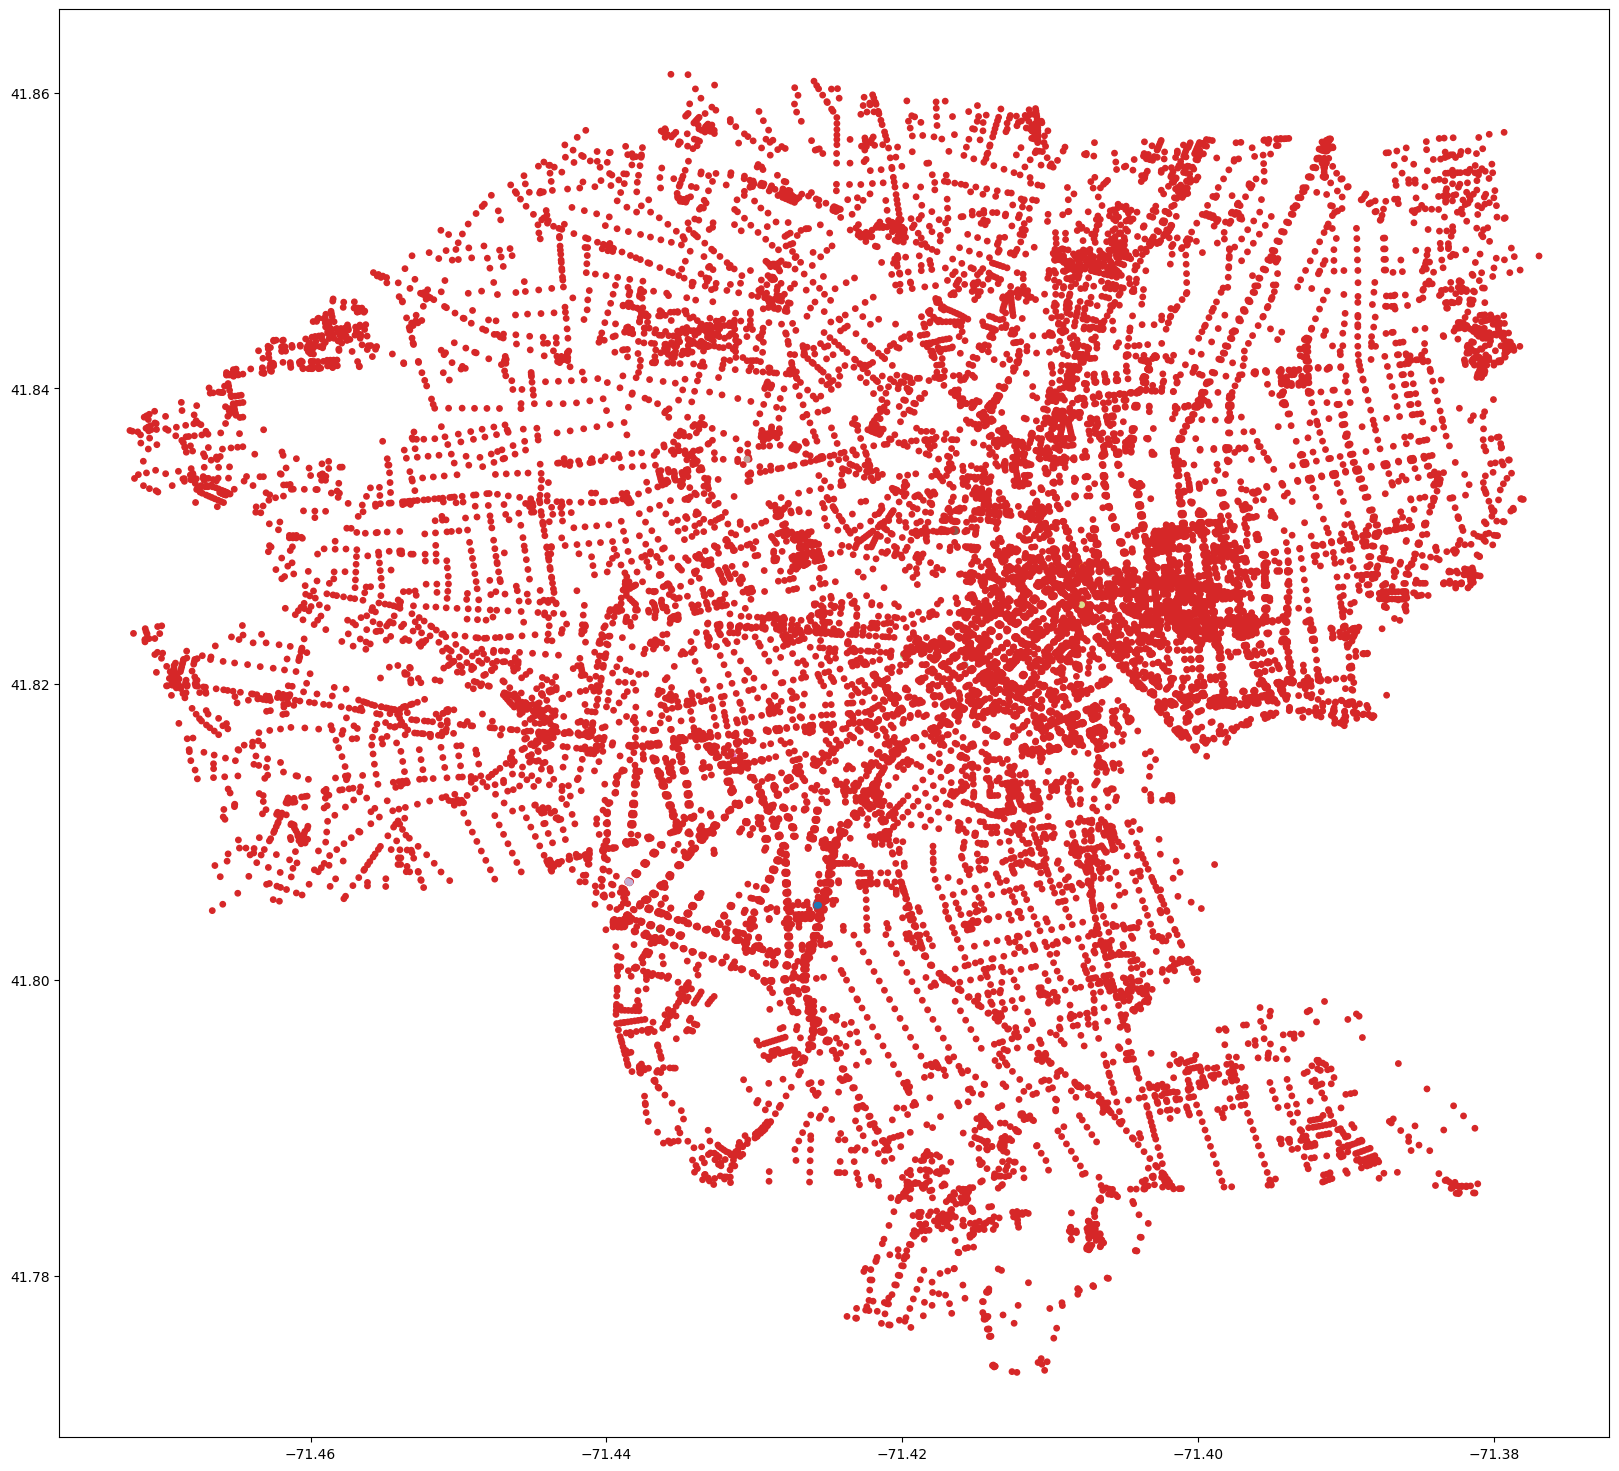

In [3]:
import networkx as nx
import scipy

K = 20
for u,v,d in G.edges(data=True):
    d['inverse_length'] = 1.0 / d['length']
A = nx.adjacency_matrix(G, weight='inverse_length')

A.indices = A.indices.astype(np.int32)
A.indptr = A.indptr.astype(np.int32)
adj_inv_length_kmeans = KMeans(n_clusters=K).fit(scipy.sparse.csr_matrix(A))
cmap = plt.get_cmap('tab20')
geo_df["label_adj_inv_length"] = [matplotlib.colors.rgb2hex(cmap(i)) for i in adj_inv_length_kmeans.labels_]
plot = geo_df.plot(
    markersize=S,
    c=geo_df["label_adj_inv_length"], 
)

In [4]:
import collections
collections.Counter(adj_inv_length_kmeans.labels_)

Counter({6: 19932,
         0: 4,
         10: 3,
         9: 3,
         19: 2,
         2: 2,
         12: 1,
         18: 1,
         1: 1,
         5: 1,
         7: 1,
         14: 1,
         8: 1,
         4: 1,
         3: 1,
         15: 1,
         13: 1,
         17: 1,
         16: 1,
         11: 1})

/courses/PHYS7332.202510/shared/sad-ml/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


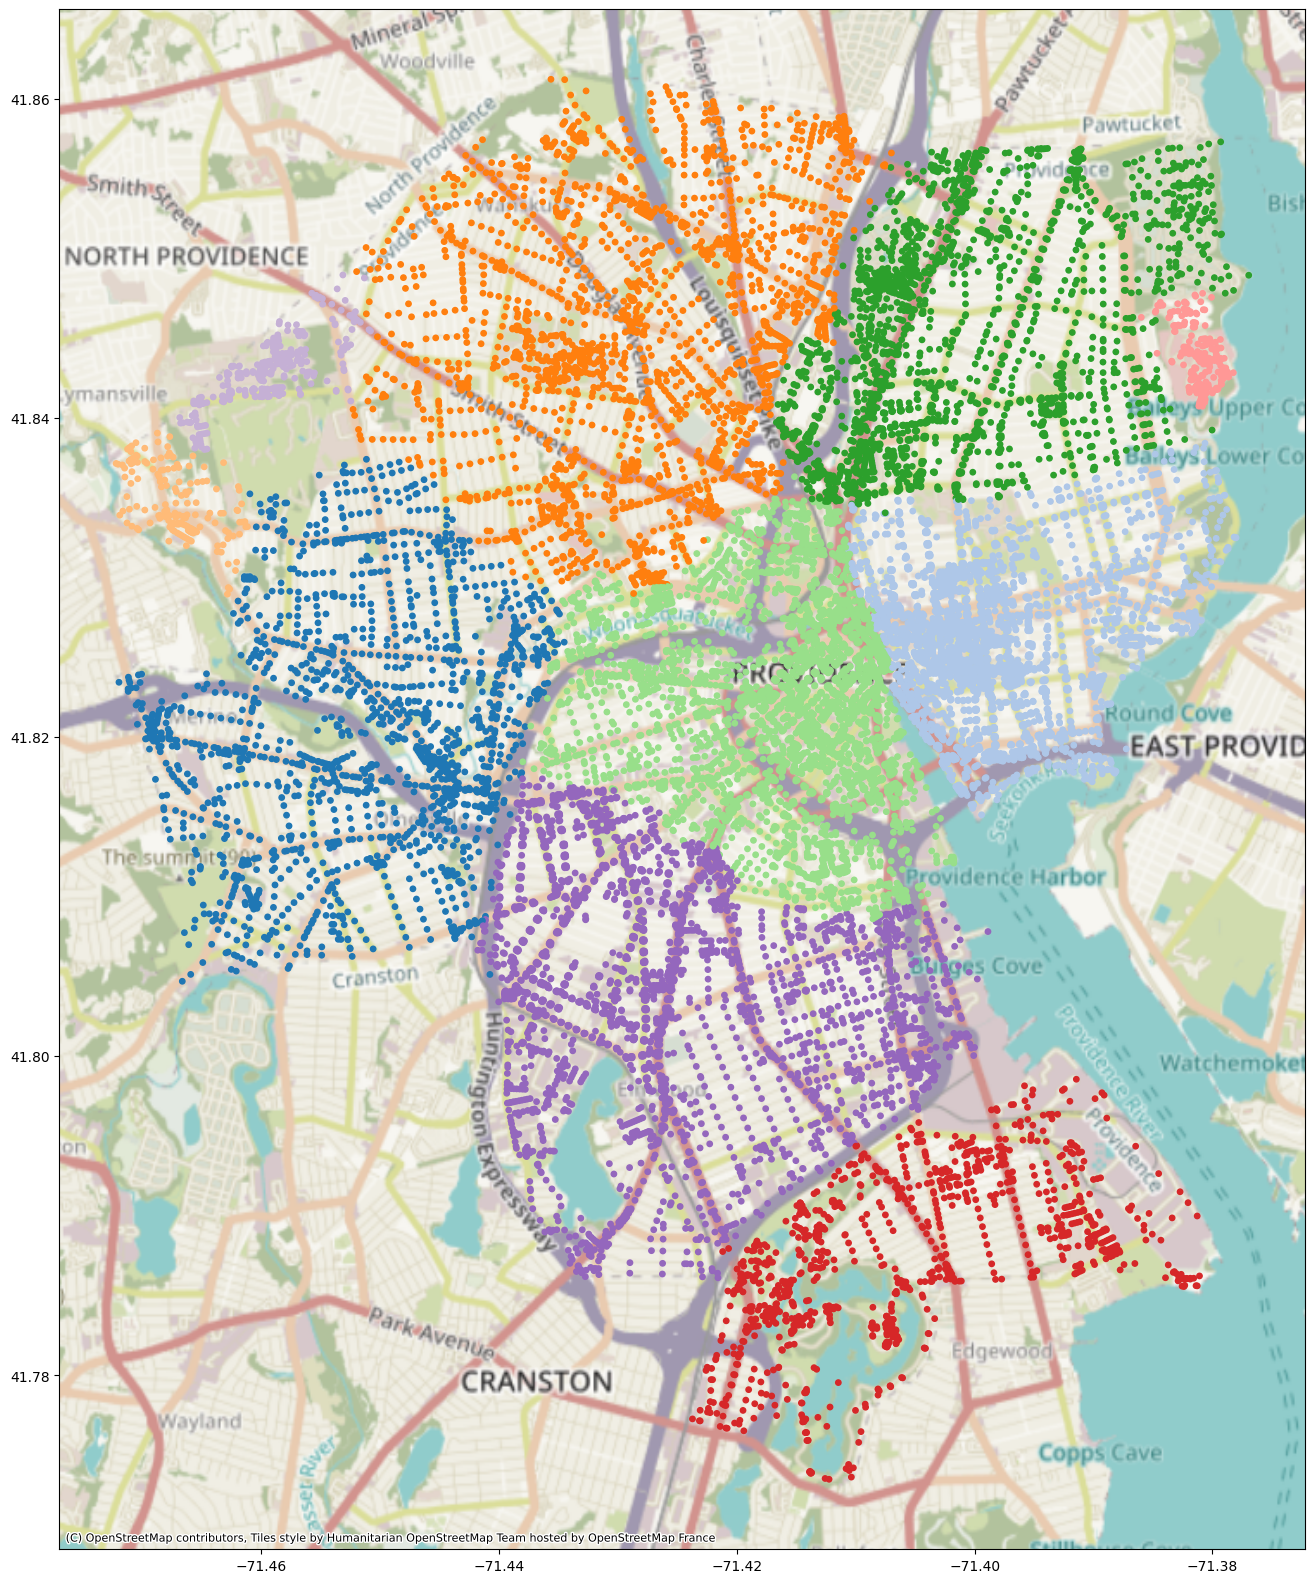

In [52]:
from sklearn.cluster import SpectralClustering

K = 10
for u,v,d in G.edges(data=True):
    d['inverse_length'] = 1.0 / d['length']
A = nx.adjacency_matrix(G, weight='inverse_length')

A.indices = A.indices.astype(np.int32)
A.indptr = A.indptr.astype(np.int32)
adj_inv_length_kmeans = SpectralClustering(n_clusters=K, affinity='precomputed').fit(scipy.sparse.csr_matrix(A))
cmap = plt.get_cmap('tab20')
geo_df["label_adj_inv_length"] = [matplotlib.colors.rgb2hex(cmap(i)) for i in adj_inv_length_kmeans.labels_]
plot = geo_df.plot(
    markersize=S,
    c=geo_df["label_adj_inv_length"], 
)
cx.add_basemap(plot, crs=geo_df.crs.to_string())


### Low-Dimensional Representations

## Newer Unsupervised ML
### Embeddings
### \*tovec

training code borrowed from pytorch and can be found [here](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/node2vec.py). 

In [38]:
from torch_geometric.nn import Node2Vec 
from torch_geometric.data import Data
import torch
import sys
from torch_geometric.transforms import RandomNodeSplit
import torch_geometric.transforms as T
for idx, node in enumerate(G.nodes):
    G.nodes[node]['idx'] = idx

my_tensor = []
for e in G.edges:
    
    my_tensor.append([G.nodes[e[0]]['idx'], G.nodes[e[1]]['idx']])

edge_list = torch.Tensor(my_tensor).T.to(torch.long)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = Node2Vec(
    edge_list,
    embedding_dim=64,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)



for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

cuda


/courses/PHYS7332.202510/shared/sad-ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 001, Loss: 3.9860
Epoch: 002, Loss: 1.9999
Epoch: 003, Loss: 1.3633
Epoch: 004, Loss: 1.0689
Epoch: 005, Loss: 0.9304
Epoch: 006, Loss: 0.8610
Epoch: 007, Loss: 0.8223
Epoch: 008, Loss: 0.7989
Epoch: 009, Loss: 0.7842
Epoch: 010, Loss: 0.7743
Epoch: 011, Loss: 0.7674
Epoch: 012, Loss: 0.7624
Epoch: 013, Loss: 0.7589
Epoch: 014, Loss: 0.7561
Epoch: 015, Loss: 0.7540
Epoch: 016, Loss: 0.7525
Epoch: 017, Loss: 0.7514
Epoch: 018, Loss: 0.7507
Epoch: 019, Loss: 0.7499
Epoch: 020, Loss: 0.7496
Epoch: 021, Loss: 0.7490
Epoch: 022, Loss: 0.7487
Epoch: 023, Loss: 0.7487
Epoch: 024, Loss: 0.7483
Epoch: 025, Loss: 0.7483
Epoch: 026, Loss: 0.7482
Epoch: 027, Loss: 0.7482
Epoch: 028, Loss: 0.7481
Epoch: 029, Loss: 0.7478
Epoch: 030, Loss: 0.7479
Epoch: 031, Loss: 0.7479
Epoch: 032, Loss: 0.7479
Epoch: 033, Loss: 0.7476
Epoch: 034, Loss: 0.7478
Epoch: 035, Loss: 0.7474
Epoch: 036, Loss: 0.7474
Epoch: 037, Loss: 0.7475
Epoch: 038, Loss: 0.7474
Epoch: 039, Loss: 0.7472
Epoch: 040, Loss: 0.7472


In [39]:
model.eval()
z = model()
z_cpu = z.to('cpu').detach().numpy()

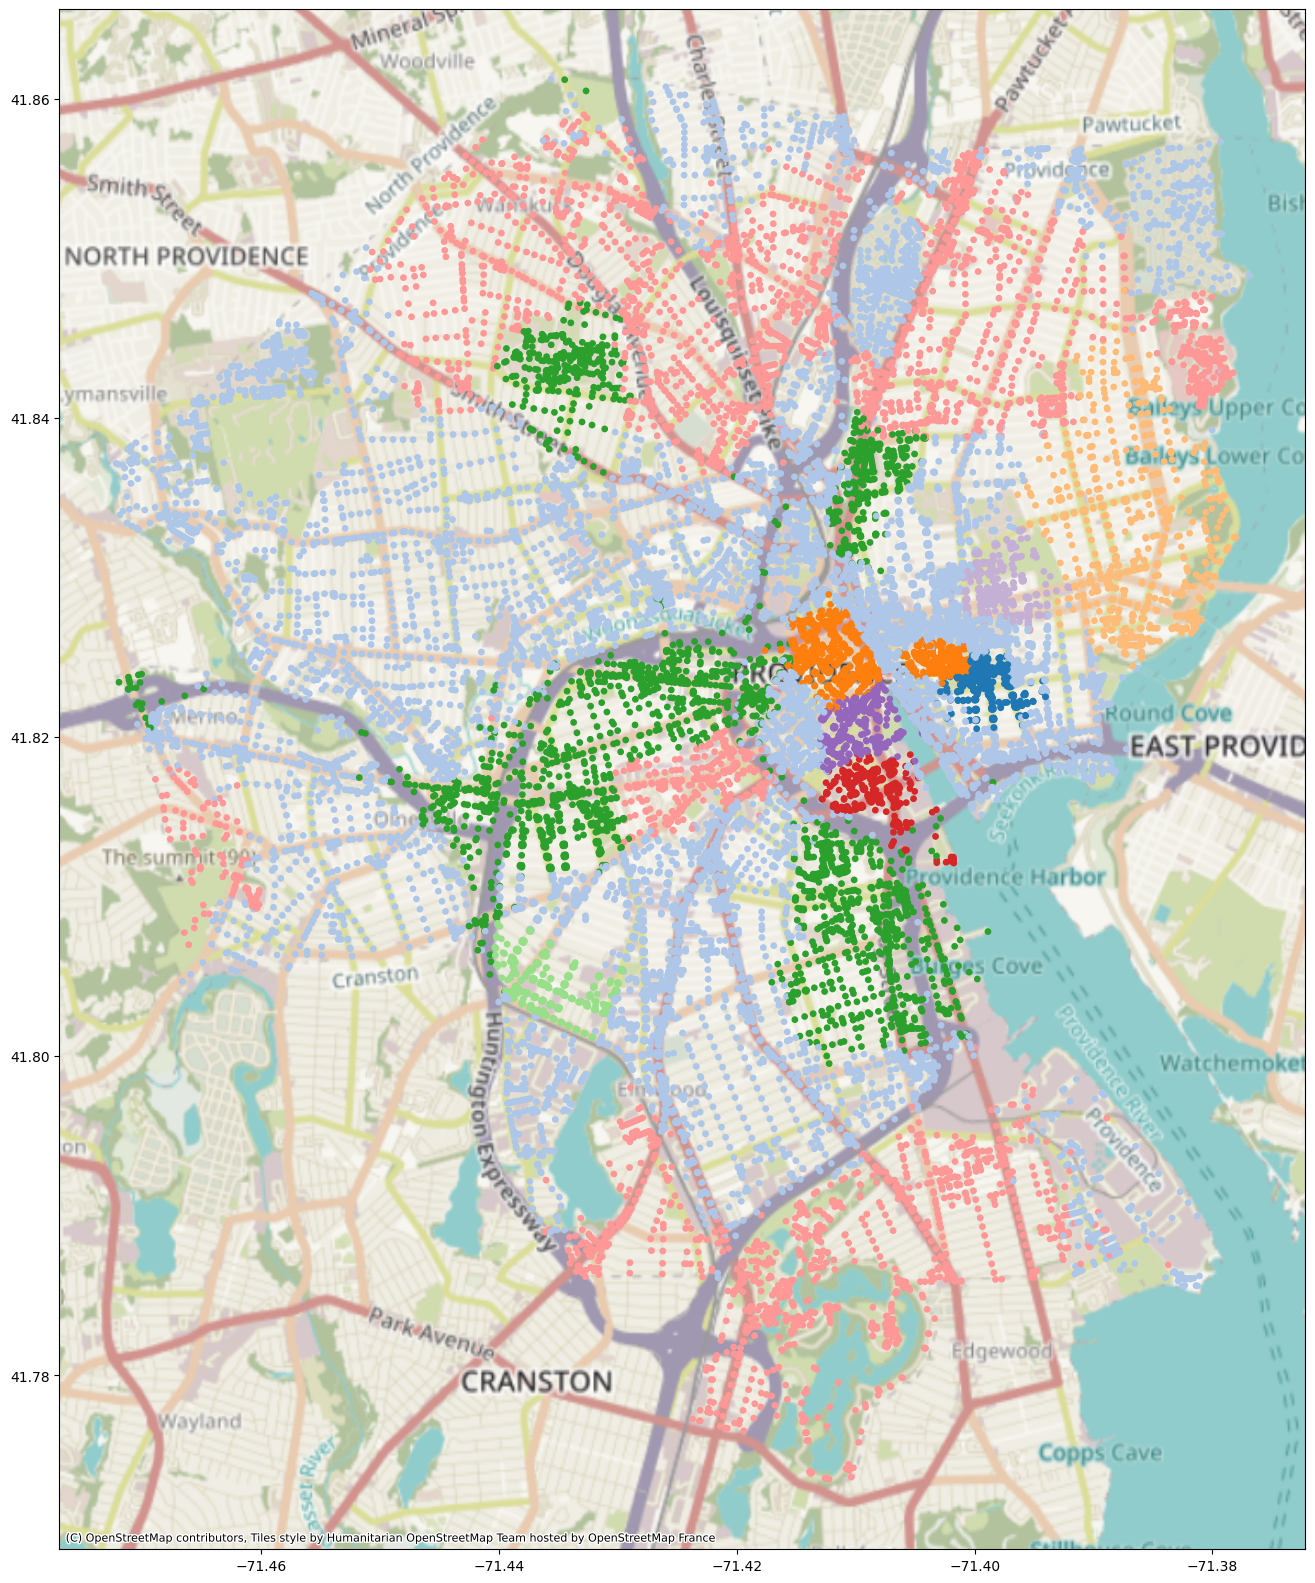

In [53]:
import contextily as cx
plt.rcParams['figure.figsize'] = (20, 20)
adj_inv_length_kmeans = KMeans(n_clusters=10).fit(z_cpu)
geo_df["label_adj_inv_length"] = [matplotlib.colors.rgb2hex(cmap(i)) for i in adj_inv_length_kmeans.labels_]
plot = geo_df.plot(
    markersize=S,
    c=geo_df["label_adj_inv_length"], 
)
cx.add_basemap(plot, crs=geo_df.crs.to_string())